# March Madness Machine Learning Workshop -- Predicting Postseason Success

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sb 
import matplotlib.pyplot as plt

Import the dataset that contains information on teams' in-season and post-season statistics.

In [ ]:
mm = pd.read_csv("data/cbb.csv")
mm = mm.dropna(axis = 0)
mm

Let us start by doing some basic exploratory data analytics on this data. We want to see if we can understand what variables correlate with what other variables, so we can create a correlation matrix and then convert that to a heatmap. 

In [ ]:
corrM = mm.corr()

<AxesSubplot:>

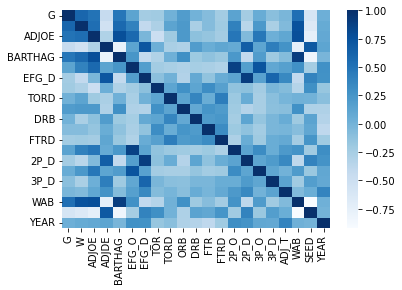

In [ ]:
sb.heatmap(corrM, cmap = "Blues")

This correlation matrix only represents numerical values in the data, so things such as team names and rounds in the bracket are not displayed.  However, from this, we can see that there are some variables, such as G, ADJOE, and BARTHAG that are highly correlated with one another. This means that dimension reduction might be useful when applying a machine learning model to the data.

We also want to understand if there are teams that appear much more drastically in the tournament than other teams do. In order to do this, we create a bar chart based on the team names and their counts.

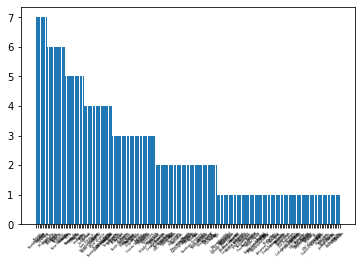

In [ ]:
val_counts = mm['TEAM'].value_counts()
plt.bar(list(val_counts.index), list(val_counts.values))
plt.xticks(rotation = 45, fontsize = 3)
plt.show()

We can see from this that there are some teams that show up more frequently in the bracket than other teams. Depending on how you look at this, you may want to include the team name in your modeling, you may not. In this case, I chose to read this as some teams have more experience in the post-season that may benefit them, and I am including that in the machine learning aspect of this problem.

Next, we need to convert TEAM and CONF variables to integer values because most built-in classification methods cannot handle categorical/textual data. 
<br />
<br />
The best way to do this is to create dummy variables. Dummy variables basically are booleans that replace textual data. If you have a column called "Letters" and the values are [a,b,c], then get_dummies() changes that column into three columns where there is a 1 either in the a, b, or c column that represents the categorical value for that row.

In [ ]:
postseason = mm['POSTSEASON']
mm = mm.drop('POSTSEASON', axis = 1)
dummies = pd.get_dummies(mm)
dummies

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,CONF_P12,CONF_Pat,CONF_SB,CONF_SC,CONF_SEC,CONF_SWAC,CONF_Slnd,CONF_Sum,CONF_WAC,CONF_WCC
0,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,...,0,0,0,0,0,0,0,0,0,0
1,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,...,0,0,0,0,0,0,0,0,0,0
2,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,...,0,0,0,0,0,0,0,0,0,0
3,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,...,0,0,0,0,0,0,0,0,0,0
4,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,19.2,36.1,...,0,0,0,0,0,0,0,0,0,0
2451,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,19.8,35.0,...,1,0,0,0,0,0,0,0,0,0
2452,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,22.0,35.8,...,1,0,0,0,0,0,0,0,0,0
2453,34,24,112.0,96.2,0.8516,51.9,49.3,17.1,21.3,29.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dummies['POSTSEASON'] = postseason

Then we want to select any variables that we do not think will be helpful. In this case, I am choosing to remove the year variables, as I only want to focus on a team's game stats, and not the year that they took place, in order to predict how far teams will go long term in the game. You can select what variables you want to include in your model by thinking through your assumptions about what variables are most highly correlated. You can even use a correlation matrix to best determine the highest correlations between each variable and your target variable.

In [ ]:
mm = dummies.drop('YEAR', axis = 1)

We then want to split into training and testing. Because there might be some order imposed on your dataset to start with, shuffling the data helps to remove that order so that a model doesn't accidentally learn it.

In [ ]:
X = mm.drop('POSTSEASON', axis = 1)
Y = mm["POSTSEASON"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.25, shuffle=True)

Now we want to consider what method of classification we are going to use. There are many different types classification methods. The following are just a subset of them:
- Decision Tree/Random Forest: dataset attributes become nodes or branches of a tree 
    - Pros: works well with both numerical and categorical data, implicitly performs feature selection, not greatly influenced by outliers
    - Cons: not easily interpretable, computationally intensive
- K-Nearest Neighbors: creates groups based off of the k-nearest values to some centroid
    - Pros: very simple, easy to implement for multi-class problems, many distance variables to choose from
    - Cons: very sensitive to outliers, slow and performs worse for higher dimensions of data
- Support Vector Machines: model with associated learning algorithms that analyze data for classifications
    - Pros: works well with clear margin of separation, effective in high dimensions
    - Cons: doesn't perform well on noisy data, no probability estimates

For this demonstration, we are going to work with a random forest algorithm. We need to start by determining what the best parameters are based on our data for our random forest algorithm. To do this we are going to create a pipeline that contains the algorithm and parameters we want to train, followed by a grid search which will test a variety of values for each and return the best fit on the training data.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [ ]:
pipe = Pipeline([['reduction', PCA()], ['classify', RandomForestClassifier()]])
pipe_grid = { 'reduction__n_components': [2, 5, 8, 10], 'classify__n_estimators': [10, 100, 1000], 'classify__criterion': ["gini", "entropy", "log_loss"]}
gs = GridSearchCV(pipe, pipe_grid)
gs.fit(X_train, y_train)
best_parameters = gs.best_params_

In [ ]:
best_parameters

Once we have the best parameters, we want to be able to test our model using our X_test and y_test values. We start by reducing the dimensions of our data using the best computed parameter. We then fit the X_train and y_train data to the RandomForestClassifier with the values that we received from the GridSearchCV best parameters. We then predict on the X_test data to get a prediction for y.

In [ ]:
pca = PCA(n_components = best_parameters['reduction__n_components'])
X_train = pca.fit_transform(X_train)

In [ ]:
model = RandomForestClassifier(n_estimators = best_parameters['classify__n_estimators'], criterion = best_parameters['classify__criterion'])
fitted_model = model.fit(X_train, y_train)
y_predicted = fitted_model.predict(pca.fit_transform(X_test))

Now we want to test how well our algorithm performed on our testing data. We can do this in many different ways. One way is by computing the accuracy and precision scores using the sklearn.metrics library. The definition of both are as follows:
- Accuracy Score: an evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made
- Precision Score: the ratio of true positive to the sum of true positive and false positive

Another great way to determine the intricacies of how our model is doing is by generating the confusion matrix which shows both how many times the model got the right answer for each classification, but also how many misclassifications occured per category.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
cm = confusion_matrix(y_test, y_predicted, labels = mm['POSTSEASON'].unique())
acc = accuracy_score(y_test, y_predicted)
prec = precision_score(y_test, y_predicted, average = "weighted")
print("Accuracy Score: " + str(acc))
print("Precision Score: " + str(prec))

In [ ]:
sb.heatmap(cm, annot = True, cmap="Blues", xticklabels = mm['POSTSEASON'].unique(), yticklabels = mm['POSTSEASON'].unique())

Although our model is far from perfect, we can see here that when it makes mistakes, it often misclassifies by only a round (for example, it classifies two elite 8's as sweet 16's, 21 round 64's as round 32's, etc.) This shows us that we are on the right track, because even though we have a lower accuracy score, the model is finding some noteworthy trends in the data. 